In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())


In [3]:
daily = pd.read_csv("Targets/daily_crsp_sanitized.csv", nrows = 1600000)
daily['date'] = pd.to_datetime(daily['date'], format = "%Y-%m-%d")
daily = daily[daily['date'] >= '2000-01-31'] # Start at the end of January to align with predictors data
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218
...,...,...,...,...,...,...,...
1599995,2000-10-05,7557,87426,3442,0,0.000000,0.001367
1599996,2000-10-05,7558,90879,8090,0,0.051095,0.001367
1599997,2000-10-05,7569,86685,6020,0,0.007500,0.001367
1599998,2000-10-05,7572,89675,3312,0,-0.050463,0.001367


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

158482     2000-01
166811     2000-02
333239     2000-03
524367     2000-04
682344     2000-05
865365     2000-06
1048421    2000-07
1214853    2000-08
1407308    2000-09
1573891    2000-10
Name: year_month, dtype: period[M]

In [5]:
index_df = pd.read_csv('Predictors/FirmCharacIndex.csv')
index_df

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-3.107469
1,1,2000-01-31,10089,12143,-1.304217
2,2,2000-01-31,10155,12094,-2.892794
3,3,2000-01-31,10182,12171,5.863377
4,4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...,...
520167,520167,2024-12-31,93426,185138,-0.052260
520168,520168,2024-12-31,93427,179583,3.371618
520169,520169,2024-12-31,93429,184500,5.908846
520170,520170,2024-12-31,93434,184259,-4.831854


In [7]:
merged = utils.merge_pls_with_asof(daily, index_df)
merged = merged.fillna(0)
merged

Processing 7762 common PERMNOs...
Processing PERMNO 1/7762
Processing PERMNO 1001/7762
Processing PERMNO 2001/7762
Processing PERMNO 3001/7762
Processing PERMNO 4001/7762
Processing PERMNO 5001/7762
Processing PERMNO 6001/7762
Processing PERMNO 7001/7762
Adding 1242 PERMNOs without PLS data...
Combining results...


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,0.000000
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,0.000000
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,0.000000
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,0.000000
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,0.000000
...,...,...,...,...,...,...,...,...,...
1441513,2000-10-05,7428,92690,6798,0,-0.006711,0.001367,2000-10,0.710286
1441514,2000-10-05,7407,92807,6020,0,0.000000,0.001367,2000-10,0.117273
1441515,2000-10-05,7378,92874,3690,0,-0.059701,0.001367,2000-10,-0.907260
1441516,2000-10-05,7323,92930,3714,0,-0.011321,0.001367,2000-10,4.626466


In [8]:
# Keeping track of the return over all the data
all_strategy_returns = []

for i in range(0, len(unique_months) - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (merged['year_month'] >= train_start) & (merged['year_month'] <= train_end)
    test_mask = merged['year_month'] == test_month

    tr_df = merged[train_mask].copy()
    te_df = merged[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

    #print(test_df.shape)
    
    train_losses, test_losses, train_sharpes, test_sharpes, strat_returns = utils.train_DNN(train_df, test_df, features, cat_features, epochs=4)

    #print(strat_returns.shape)
    # Right after getting strat_returns
    #print(f"strat_returns stats: min={strat_returns.min()}, max={strat_returns.max()}, nan_count={strat_returns.isna().sum()}")
    #print(f"strat_returns shape: {strat_returns.shape}")
    #print(f"test_df shape: {test_df.shape}")

    # Add strat_returns as a new column to test_df
    #test_df['strat_return'] = strat_returns 

    # After assigning to test_df
    test_df['strat_return'] = strat_returns.values 
    #print(f"test_df['strat_return'] nan_count: {test_df['strat_return'].isna().sum()}")

    # Calculate mean returns by date
    mean_daily_returns = test_df.groupby('date')['strat_return'].mean()

    # Check if the groupby operation is the issue
    #mean_daily_returns = test_df.groupby('date')['strat_return'].mean()
    #print(f"mean_daily_returns nan_count: {mean_daily_returns.isna().sum()}")
    
    #print(mean_daily_returns.shape)
    all_strategy_returns.append(mean_daily_returns)






# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:18<00:54, 18.17s/it]

Epoch 1/4, Loss: -0.7709, Train Sharpe: 1.6904, Test Sharpe: 1.5166


Training:  75%|██████████████████████████▎        | 3/4 [00:53<00:17, 17.86s/it]

Epoch 3/4, Loss: -1.8320, Train Sharpe: 2.1324, Test Sharpe: 1.9333


Training: 100%|███████████████████████████████████| 4/4 [01:11<00:00, 17.80s/it]

Epoch 4/4, Loss: -1.9225, Train Sharpe: 2.1975, Test Sharpe: 1.9968
Training completed! Best test Sharpe ratio: 1.9968
Training from 2000-02 to 2000-08. Testing on 2000-09.


['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.43s/it]

Epoch 1/4, Loss: -0.8479, Train Sharpe: 1.8217, Test Sharpe: 1.7333


Training:  75%|██████████████████████████▎        | 3/4 [01:05<00:22, 22.27s/it]

Epoch 3/4, Loss: -1.8443, Train Sharpe: 2.1677, Test Sharpe: 2.0546


Training: 100%|███████████████████████████████████| 4/4 [01:25<00:00, 21.31s/it]

Epoch 4/4, Loss: -1.9078, Train Sharpe: 2.1524, Test Sharpe: 2.0401
Training completed! Best test Sharpe ratio: 2.0546
Training from 2000-03 to 2000-09. Testing on 2000-10.


['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 7 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:58, 19.56s/it]

Epoch 1/4, Loss: -0.8532, Train Sharpe: 1.7051, Test Sharpe: 1.7183


Training:  75%|██████████████████████████▎        | 3/4 [00:57<00:19, 19.12s/it]

Epoch 3/4, Loss: -1.8257, Train Sharpe: 2.0000, Test Sharpe: 2.0093


Training: 100%|███████████████████████████████████| 4/4 [01:16<00:00, 19.21s/it]

Epoch 4/4, Loss: -1.8970, Train Sharpe: 2.1006, Test Sharpe: 2.1115
Training completed! Best test Sharpe ratio: 2.1115


In [9]:
combined_returns

date
2000-08-01    0.084564
2000-08-02    0.083120
2000-08-03    0.083824
2000-08-04    0.082608
2000-08-07    0.083871
2000-08-08    0.082700
2000-08-09    0.082445
2000-08-10    0.081843
2000-08-11    0.080832
2000-08-14    0.082539
2000-08-15    0.082775
2000-08-16    0.081867
2000-08-17    0.080206
2000-08-18    0.079622
2000-08-21    0.081146
2000-08-22    0.080276
2000-08-23    0.081286
2000-08-24    0.080970
2000-08-25    0.078774
2000-08-28    0.081721
2000-08-29    0.080855
2000-08-30    0.081136
2000-08-31    0.083239
2000-09-01    0.083332
2000-09-05    0.086507
2000-09-06    0.086683
2000-09-07    0.084976
2000-09-08    0.086630
2000-09-11    0.085632
2000-09-12    0.083739
2000-09-13    0.083975
2000-09-14    0.083846
2000-09-15    0.086447
2000-09-18    0.090021
2000-09-19    0.087135
2000-09-20    0.085278
2000-09-21    0.086014
2000-09-22    0.087952
2000-09-25    0.087181
2000-09-26    0.087318
2000-09-27    0.085883
2000-09-28    0.087959
2000-09-29    0.088447
2000-1

<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

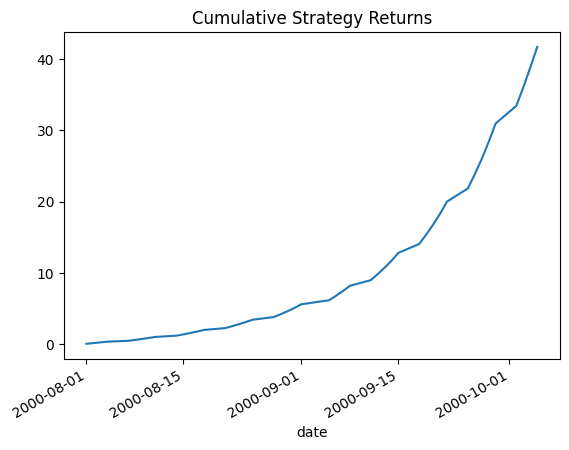

In [10]:
# Handle duplicate dates (if any) by taking the mean
#combined_returns = combined_returns.groupby(level=0).mean()

# Sort by date to ensure chronological order
combined_returns = combined_returns.sort_index()

# Convert to DataFrame and calculate cumulative returns
results_df = pd.DataFrame({
    'daily_return': combined_returns,
    'cumulative_return': (1 + combined_returns).cumprod() - 1  # Geometric compounding
})

# Now you can plot:
results_df['cumulative_return'].plot(title='Cumulative Strategy Returns')